Processing stocks: 100%|██████████| 2979/2979 [00:09<00:00, 306.09it/s]


     A   AA  AACT-UN  AAMC  AAN  AAP  AAT   AB  ABBV  ABEV  ...  ZGN   ZH  \
0  0.0  0.0      0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
1  0.0  0.0      0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
2  0.0  0.0      0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
3  0.0  0.0      0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   
4  0.0  0.0      0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  ...  0.0  0.0   

   ZIM  ZIP  ZTO  ZTR  ZTS  ZUO  ZVIA  ZWS  
0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  

[5 rows x 2979 columns]
          A     AA  AACT-UN  AAMC  AAN    AAP  AAT     AB  ABBV   ABEV  ...  \
3448 -0.022  0.073      0.0   0.0  0.0 -0.031  0.0  0.013   0.0 -0.058  ...   
3449 -0.013  0.069      0.0   0.0  0.0 -0.049  0.0  0.007   0.0 -0.060  ...   
3450 

Elbow Method: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


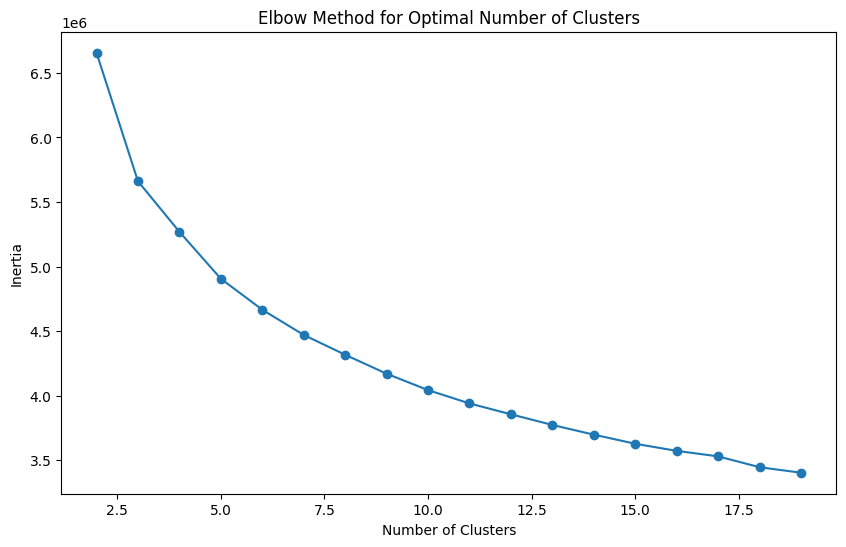

Silhouette Score: 100%|██████████| 18/18 [00:24<00:00,  1.34s/it]


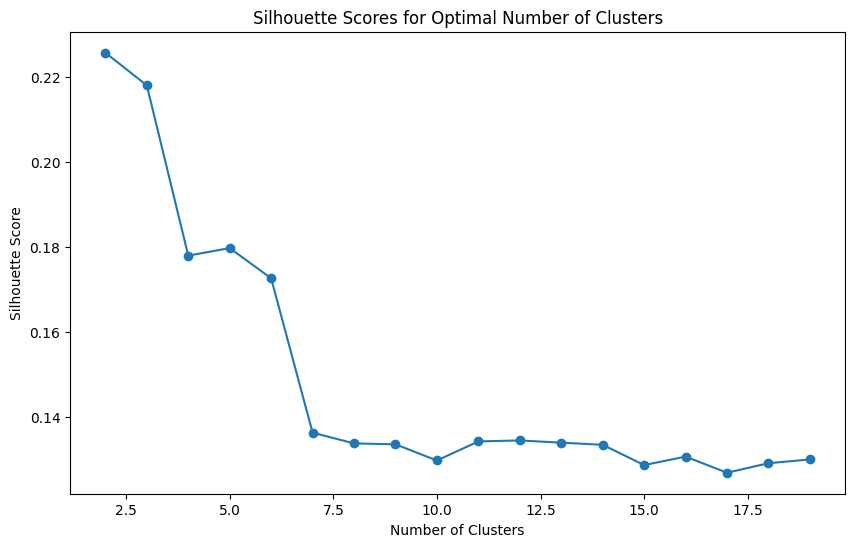

Calculating Group Correlations: 100%|██████████| 8/8 [00:00<00:00, 420.57it/s]

       Ticker  Cluster
0           A        6
1          AA        6
2     AACT-UN        0
3        AAMC        3
4         AAN        3
5         AAP        7
6         AAT        4
7          AB        1
8        ABBV        5
9        ABEV        1
10        ABG        1
11        ABM        1
12     ABR-PD        3
13     ABR-PE        7
14     ABR-PF        7
15        ABR        1
16        ABT        2
17         AC        0
18        ACA        4
19       ACCO        2
20       ACEL        7
21       ACHR        7
22        ACI        5
23        ACM        1
24        ACN        1
25     ACP-PA        7
26        ACP        0
27     ACR-PC        7
28     ACR-PD        7
29        ACR        1
30       ACRE        0
31        ACU        1
32        ACV        0
33     ADC-PA        0
34        ADC        7
35       ADCT        5
36        ADM        6
37       ADNT        5
38       ADRT        4
39        ADT        7
40        ADX        1
41         AE        7
42        A

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from numba import njit

data_dir = 'Data/RFpredictions'

# Load Parquet files into data_frames dictionary
data_frames = {}
files = [file for file in os.listdir(data_dir) if file.endswith('.parquet')]
for file in tqdm(files, desc="Loading Parquet files"):
    ticker = file.split('.')[0]
    # Load the parquet file but drop all columns except 'Close'
    data_frames[ticker] = pd.read_parquet(os.path.join(data_dir, file))[['Close']]

@njit
def calculate_dynamic_weights(volatility, mean_volatility, std_volatility):
    if std_volatility == 0:
        return np.array([0.25, 0.25, 0.25, 0.25])
    
    z_score = (volatility - mean_volatility) / std_volatility
    weights = np.array([0.25 - 0.1*z_score, 0.25 - 0.05*z_score, 0.25 + 0.05*z_score, 0.25 + 0.1*z_score])
    weights = np.maximum(np.minimum(weights, 1), 0)  # This replaces np.clip
    return weights / np.sum(weights)

@njit
def calculate_weighted_returns_fast(returns, volatility, mean_volatility, std_volatility):
    weighted_returns = np.zeros(len(returns))
    for i in range(21, len(returns)):
        weights = calculate_dynamic_weights(volatility[i], mean_volatility[i], std_volatility[i])
        weighted_returns[i] = np.sum(returns[i] * weights)
    return weighted_returns

def process_stock_data(df):
    if df['Close'].isnull().all():
        return df

    df['Daily_Return'] = df['Close'].pct_change().fillna(0).round(3)
    df['Weekly_Return'] = df['Close'].pct_change(5).fillna(0).round(3)
    df['Monthly_Return'] = df['Close'].pct_change(21).fillna(0).round(3)
    df['Yearly_Return'] = df['Close'].pct_change(252).fillna(0).round(3)

    df['Volatility'] = df['Daily_Return'].rolling(window=21).std().fillna(0)
    df['Mean_Volatility'] = df['Volatility'].rolling(window=21).mean().fillna(0)
    df['Volatility_Std'] = df['Volatility'].rolling(window=21).std().fillna(0)

    returns = np.column_stack((df['Daily_Return'], df['Weekly_Return'], df['Monthly_Return'], df['Yearly_Return']))
    volatility = df['Volatility'].values
    mean_volatility = df['Mean_Volatility'].values
    std_volatility = df['Volatility_Std'].values

    df['Weighted_Return'] = calculate_weighted_returns_fast(returns, volatility, mean_volatility, std_volatility)
    df['Weighted_Return'] = df['Weighted_Return'].round(3)

    ##remove the first 21 days of data
    df = df[21:]
    #remove the last 21 days of data
    df = df[:-21]




    # If there are any NaN values in the dataframe, fill them with 0
    df.fillna(0, inplace=True)
    return df

# Process all stocks
for ticker, df in tqdm(data_frames.items(), desc="Processing stocks"):
    data_frames[ticker] = process_stock_data(df)

returns_df = pd.DataFrame({ticker: df['Weighted_Return'] for ticker, df in data_frames.items()}).fillna(0)

print(returns_df.head())
print(returns_df.tail())
print(returns_df.shape)
print(returns_df.isnull().sum())
print(returns_df.describe())

correlation_matrix = returns_df.corr().fillna(0)

# Ensure no NaNs in the correlation matrix
correlation_matrix.dropna(how='any', inplace=True)
correlation_matrix.dropna(how='any', axis=1, inplace=True)

# Check if correlation_matrix is empty
if correlation_matrix.empty:
    print("correlation_matrix is empty after dropping NaNs. Exiting.")
    exit()

scaler = StandardScaler()
scaled_correlation = scaler.fit_transform(correlation_matrix)

# Perform clustering
kmeans = KMeans(n_clusters=8, random_state=0, n_init=10)
clusters = kmeans.fit_predict(scaled_correlation)

correlation_matrix_df = pd.DataFrame(correlation_matrix)
correlation_matrix_df['Cluster'] = clusters

# Elbow Method
inertia = []
for k in tqdm(range(2, 20), desc="Elbow Method"):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(scaled_correlation)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in tqdm(range(2, 20), desc="Silhouette Score"):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(scaled_correlation)
    silhouette_scores.append(silhouette_score(scaled_correlation, labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.show()

clustered_assets = correlation_matrix_df[['Cluster']].reset_index()
clustered_assets.columns = ['Ticker', 'Cluster']

EPSILON = 0.0001

def clip_and_round_correlations(correlation_matrix, epsilon=EPSILON, decimals=5):
    """
    Clip correlation values to a minimum absolute value (epsilon) and round to specified decimal places.
    """
    clipped_matrix = np.where(np.abs(correlation_matrix) < epsilon, 
                              np.sign(correlation_matrix) * epsilon, 
                              correlation_matrix)
    return np.round(clipped_matrix, decimals)

def calculate_group_correlations_vectorized(correlation_matrix, clustered_assets):
    corr_array = correlation_matrix.values
    unique_clusters = clustered_assets['Cluster'].unique()
    cluster_indices = {cluster: clustered_assets.index[clustered_assets['Cluster'] == cluster].tolist() 
                       for cluster in unique_clusters}
    
    result = pd.DataFrame(index=correlation_matrix.index, 
                          columns=[f'correlation_{cluster}' for cluster in unique_clusters])
    
    for cluster in tqdm(unique_clusters, desc="Calculating Group Correlations"):
        indices = cluster_indices[cluster]
        cluster_correlations = corr_array[:, indices].mean(axis=1)
        result[f'correlation_{cluster}'] = clip_and_round_correlations(cluster_correlations)
    
    return result

group_correlations = calculate_group_correlations_vectorized(correlation_matrix, clustered_assets)

clustered_assets = clustered_assets.merge(group_correlations, left_on='Ticker', right_index=True)

mean_intra_group_corr = clustered_assets.groupby('Cluster')[group_correlations.columns].mean().mean(axis=1)
clustered_assets['mean_intragroup_correlation'] = clustered_assets['Cluster'].map(mean_intra_group_corr)
clustered_assets['diff_to_mean_group_corr'] = clustered_assets.apply(
    lambda row: row[f'correlation_{row.Cluster}'] - row['mean_intragroup_correlation'], axis=1)

reordered_columns = ['Ticker', 'Cluster', 'mean_intragroup_correlation', 'diff_to_mean_group_corr'] + list(group_correlations.columns)




clustered_assets = clustered_assets[reordered_columns].round(5)

clustered_assets.to_parquet('Correlations.parquet', index=False)

pd.set_option('display.max_rows', None)
print(clustered_assets[['Ticker', 'Cluster']])

print("Correlations saved to 'Correlations.parquet'.")


In [14]:
##lets check the correletion file to make sure we have cor data for all the tickers in the Data/RFpredictions folder
for ticker in data_frames.keys():
    if ticker not in clustered_assets['Ticker'].values:
        print(f"Missing correlation data for {ticker}")
    else:
        print(f"Correlation data found for {ticker}")

Correlation data found for A
Correlation data found for AA
Correlation data found for AACT-UN
Correlation data found for AAMC
Correlation data found for AAN
Correlation data found for AAP
Correlation data found for AAT
Correlation data found for AB
Correlation data found for ABBV
Correlation data found for ABEV
Correlation data found for ABG
Correlation data found for ABM
Correlation data found for ABR-PD
Correlation data found for ABR-PE
Correlation data found for ABR-PF
Correlation data found for ABR
Correlation data found for ABT
Correlation data found for AC
Correlation data found for ACA
Correlation data found for ACCO
Correlation data found for ACEL
Correlation data found for ACHR
Correlation data found for ACI
Correlation data found for ACM
Correlation data found for ACN
Correlation data found for ACP-PA
Correlation data found for ACP
Correlation data found for ACR-PC
Correlation data found for ACR-PD
Correlation data found for ACR
Correlation data found for ACRE
Correlation dat